<a href="https://www.kaggle.com/code/devmarkpro/churn-prediction-lr-rf-svm-catboost-eda" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Customer Churn Prediction: EDA, Preprocessing, Model Comparison, and Feature Engineering

- <a href="https://github.com/devmarkpro/telco-customer-churn-ml-project/blob/main/customer_churn_prediction_model_comparison.ipynb" target="_blank">
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub Logo" style="vertical-align: middle; width:16px; height:16px; filter: invert(0.8);">
  GitHub Repo
</a>

## Project Overview and Problem Statement

This project focuses on predicting customer churn in the telecommunications industry. Churn refers to customers who leave a service provider, and predicting churn is crucial for improving customer retention and business profitability.

The problem is formulated as a supervised learning task, where the goal is to predict a binary outcome, whether a customer will churn (Yes) or not (No).

Since the target variable is categorical with two possible outcomes, this is a binary classification problem. Various classification algorithms will be explored and compared to build a robust predictive model.
Through this project, I aim to understand which features most strongly influence customer churn, evaluate model performance using appropriate metrics (e.g., ROC-AUC, F1-score), and identify the best-performing supervised learning approach for this classification task.

## Data Source

The dataset used in this project is the Telco Customer Churn dataset, which contains customer information from a telecommunications company, including demographic details, account data, services subscribed to, and whether the customer has churned. The target variable is Churn, indicating if the customer left (Yes) or stayed (No).

The dataset is publicly available on Kaggle: [Telco Customer Churn – Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

It includes 7043 samples and 20 features, with a mix of numerical, binary, and categorical variables.

There is also a more extensive version of this dataset published by IBM, which includes more features and additional records:
[IBM Telco Customer Churn (extended version)](https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

However, for the scope of this project, we use the Kaggle version due to its simpler structure, which is more manageable for demonstrating supervised learning techniques within the project constraints.

### Dataset Explanation

The dataset consists of 7043 rows (customers) and 21 columns (20 features + 1 target variable). It is in tabular format, with each row representing a customer and each column representing a demographic, service-related, or account-related attribute.

Among the features:

- 13 are categorical (e.g., gender, InternetService, Contract)
- 3 are numerical (tenure, MonthlyCharges, TotalCharges)
- 5 are binary (SeniorCitizen, Partner, Dependents, etc.)

The dataset is self-contained (not multi-table) and does not require external data merging. It is relatively small in size (under 1 MB), making it manageable for exploratory data analysis and model experimentation.

Here's the full list of columns in the dataset

* ``customerID``: Unique ID for each customer
* ``gender``: Gender of the customer (`Male` or `Female`)
* ``SeniorCitizen``: Indicates if the customer is a senior (`1` = Yes, `0` = No)
* ``Partner``: Whether the customer has a partner (`Yes` or `No`)
* ``Dependents``: Whether the customer has dependents (`Yes` or `No`)
* ``tenure``: Number of months the customer has been with the company
* ``PhoneService``: Whether the customer has phone service (`Yes` or `No`)
* ``MultipleLines``: Has multiple phone lines (`Yes`, `No`, or `No phone service`)
* ``InternetService``: Type of internet service (`DSL`, `Fiber optic`, or `No`)
* ``OnlineSecurity``: Whether online security is included (`Yes`, `No`, or `No internet service`)
* ``OnlineBackup``: Whether online backup is included (`Yes`, `No`, or `No internet service`)
* ``DeviceProtection``: Whether device protection is included (`Yes`, `No`, or `No internet service`)
* ``TechSupport``: Whether tech support is included (`Yes`, `No`, or `No internet service`)
* ``StreamingTV``: Access to streaming TV (`Yes`, `No`, or `No internet service`)
* ``StreamingMovies``: Access to streaming movies (`Yes`, `No`, or `No internet service`)
* ``Contract``: Type of contract (`Month-to-month`, `One year`, `Two year`)
* ``PaperlessBilling``: Whether billing is paperless (`Yes` or `No`)
* ``PaymentMethod``: Method of payment (`Electronic check`, `Mailed check`, etc.)
* ``MonthlyCharges``: Monthly amount charged to the customer
* ``TotalCharges``: Total amount charged over the tenure
* ``Churn``: Target variable. Whether the customer churned (`Yes` or `No`)


In [7]:
import os
import sys
def detect_environment():
    if 'google.colab' in sys.modules:
        return 'colab'
    elif 'kaggle' in sys.modules or os.path.exists('/kaggle'):
        return 'kaggle'
    else:
        return 'local'
env = detect_environment()
print(f"running in {env}" )

running in local


In [8]:
import warnings


if env != 'local':
    !pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0 --quiet
    !pip install seaborn==0.13.2 --quiet
    !pip install matplotlib==3.10.0 --quiet
    warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")
if env == 'kaggle':
    import kagglehub
    
def get_dataset_path():
    path = ''
    
    if env == "kaggle":
        path = kagglehub.dataset_download("blastchar/telco-customer-churn")
        path += '/WA_Fn-UseC_-Telco-Customer-Churn.csv'
    if env == 'local':
        path = "./data/Telco-Customer-Churn.csv"
    if env == 'colab':
        raise ValueError("colab env is not supported yet")
    return path


def get_result_path():
    path = ''
    
    if env == "kaggle":
        path = '/kaggle/working'
    if env == 'local':
        path = "./results"
    if env == 'colab':
        raise ValueError("colab env is not supported yet")
    return path    

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import seaborn as sns
from catboost import cv, Pool, CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

In [10]:
# Constants for the EDA, preprocessing, and modeling
TARGET_COLUMN = "Churn"
RANDOM_STATE = 42
K_FOLDS = 5
RESULT_PATH = get_result_path()
RESULT_FINE_NAME = "model_comparison_results"
RESULT_FINE_EXT = "csv"
DATASET_PATH = get_dataset_path()
TEST_SIZE = 0.2
SCORING = 'roc_auc'

print(f"Dataset path: {DATASET_PATH}")
print(f"Result path: {RESULT_PATH}")


Dataset path: ./data/Telco-Customer-Churn.csv
Result path: ./results


## Exploratory Data Analysis (EDA)

### Basic Data Exploration and Preprocessing

In [11]:
df = pd.read_csv(DATASET_PATH, delimiter=',')

In [12]:
print(f'shape: {df.shape}')
print(f'columns: {df.columns.tolist()}')

shape: (7043, 21)
columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [13]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

SeniorCitizen is binary coloumn and it already `int64` type, however, we need to covert columns like gender, Partner, Dependents, etc to `category` type.

In general, we have three categories of columns:
1. Numerical columns
2. Categorical columns
3. Binary columns

However, I also consider separating features based on their domain, such as service, demographic, and payment features. This will help in understanding the data better later on.

One important thing to note is that the `TotalCharges` column is a numerical column, but it has a type of `object` due to some non-numeric values. We need to convert it to a numeric type and handle any errors that arise from non-numeric values.

Before we proceed with the conversion, let's check the unique values in each column to understand the data better.

In [14]:
# unique values in each column
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values : {df[col].unique()} unique values')

customerID: 7043 unique values : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] unique values
gender: 2 unique values : ['Female' 'Male'] unique values
SeniorCitizen: 2 unique values : [0 1] unique values
Partner: 2 unique values : ['Yes' 'No'] unique values
Dependents: 2 unique values : ['No' 'Yes'] unique values
tenure: 73 unique values : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] unique values
PhoneService: 2 unique values : ['No' 'Yes'] unique values
MultipleLines: 3 unique values : ['No phone service' 'No' 'Yes'] unique values
InternetService: 3 unique values : ['DSL' 'Fiber optic' 'No'] unique values
OnlineSecurity: 3 unique values : ['No' 'Yes' 'No internet service'] unique values
OnlineBackup: 3 unique values : ['Yes' 'No' 'No internet service'] unique values
Dev

We can see that the `gender`, `Partner`, `Dependents`, `PhoneService`, and `PaperlessBilling` columns have binary values, while the `InternetService`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies` columns are categorical with multiple unique values. The `Contract` and `PaymentMethod` columns also have categorical values.

In [15]:
demographic_features = ["gender", "SeniorCitizen", "Partner", "Dependents"]
service_features = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
                    "OnlineBackup", "DeviceProtection", "StreamingTV", "StreamingMovies", "TechSupport"]
payment_features = ["Contract", "PaperlessBilling", "PaymentMethod"]

binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
categorical_features = list(set(service_features + payment_features) - set(binary_features))
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
features = demographic_features + service_features + payment_features


In [16]:
# handling TotalCharges column
print(f'TotalCharges type before conversion: {df["TotalCharges"].dtype}, total null values: {df["TotalCharges"].isna().sum()}')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

TotalCharges type before conversion: object, total null values: 0


While converting the `TotalCharges` column to numeric, we use `errors='coerce'` to convert any non-numeric values to NaN. This is important because it allows us to handle any invalid entries without causing the entire conversion to fail. After this conversion, we can decide how to handle these NaN values, either by dropping them or filling them with a specific value.
Let's check how many NaN values we have in the `TotalCharges` column and then drop them if necessary.

In [17]:
print(f'TotalCharges type after conversion: {df["TotalCharges"].dtype}, total null values: {df["TotalCharges"].isna().sum()}')

TotalCharges type after conversion: float64, total null values: 11


Now the data type of `TotalCharges` is `float64`, but we have 11 rows with NaN values after the conversion. Let's check these rows in the original dataframe.

In [18]:
temp_df = pd.read_csv(DATASET_PATH, delimiter=',')
temp_df.loc[df[df['TotalCharges'].isnull()].index, 'TotalCharges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

It is clear that these rows have no values in the `TotalCharges` column, which is why they were converted to NaN. Since these rows do not provide any useful information for our analysis and the total number of rows is small (11), we can safely drop them from the dataset.

In [19]:
df = df.dropna(subset=['TotalCharges'])
print(f'Total null values: {df["TotalCharges"].isna().sum()}')

Total null values: 0


As we saw in the previous steps, `customerID` is a unique identifier for each customer and does not provide any useful information for our analysis. Therefore, we can drop this column from the dataset.

In [20]:
# drop customerID column
df = df.drop(columns=['customerID'])

In [21]:
# check null and duplicated values in the dataset
print(f'Total null values in the dataset: {df.isna().sum().sum()}')
print(f'Total duplicated rows in the dataset: {df.duplicated().sum()}')

Total null values in the dataset: 0
Total duplicated rows in the dataset: 22


We have 22 duplicated rows in the dataset, however, considering these are belong to different customers, we can keep them as they are. We also have no null values in the dataset, which is great.

### Target Variable Distribution

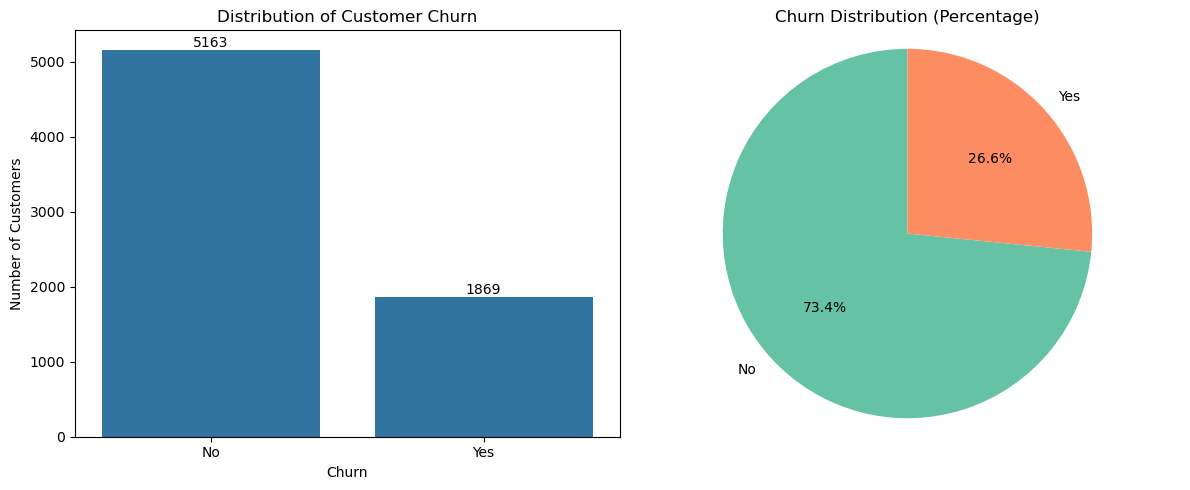

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Countplot
sns.countplot(x=TARGET_COLUMN, data=df, ax=axes[0])
axes[0].set_title("Distribution of Customer Churn")
axes[0].set_xlabel(TARGET_COLUMN)
axes[0].set_ylabel("Number of Customers")
axes[0].bar_label(axes[0].containers[0])

# Right: Pie Chart
churn_counts = df['Churn'].value_counts()
churn_percent = churn_counts / churn_counts.sum() * 100
axes[1].pie(churn_percent, labels=churn_percent.index, autopct='%1.1f%%',
            startangle=90, colors=['#66c2a5', '#fc8d62'])
axes[1].set_title("Churn Distribution (Percentage)")
axes[1].axis('equal')

plt.tight_layout()
plt.show()


Looking at the distribution of the target variable `Churn`, we can see that the dataset is imbalanced, with a higher number of customers who did not churn compared to those who did. This is a common scenario in churn prediction tasks and will require special attention during model training to ensure that the model does not become biased towards the majority class.

### Numerical Features Analysis

Let's start with the numerical feature analysis. We will check the distribution of each numerical feature and their correlation with the target variable `Churn`. Let's start with a boxplot to visualize the distribution of numerical features.

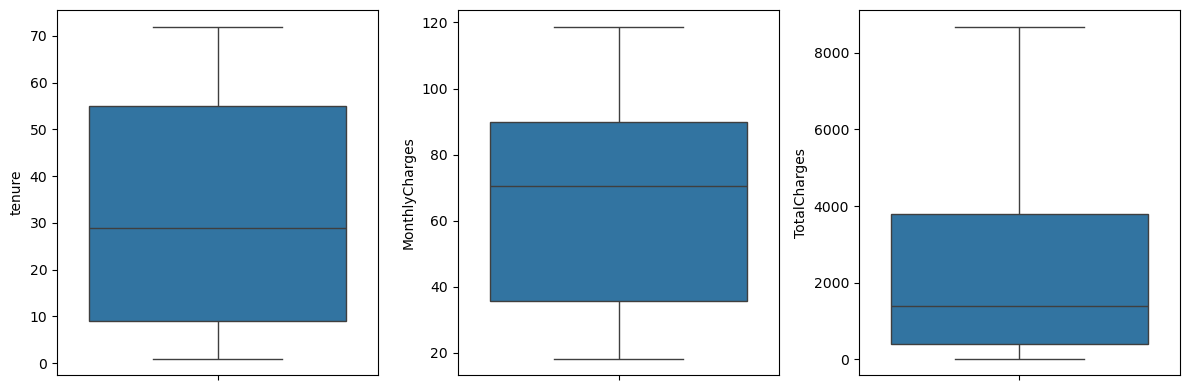

In [23]:
plt.figure(figsize=(12, 4))

for i in range(0, len(numeric_features)):
    plt.subplot(1, len(numeric_features), i + 1)
    sns.boxplot(data=df, y=numeric_features[i])
    plt.tight_layout()

**Analysis of Numerical Features**

The boxplots for `tenure`, `MonthlyCharges`, and `TotalCharges` provide insight into the distribution and spread of these numerical variables. The `tenure` feature shows a relatively wide distribution, with a median around 29 months and no visible outliers, indicating a stable range of customer contract lengths. Similarly, `MonthlyCharges` is moderately right-skewed, with most customers paying between 35 and 90 per month. There are no extreme values beyond the whiskers, suggesting that premium-tier customers fall within a reasonable range.

The `TotalCharges` feature exhibits a pronounced right skew, which is expected given its dependency on both tenure and monthly charges. Although some customers have paid significantly more over time, these values are within the expected bounds and are not treated as outliers. Overall, the numerical features appear well-behaved and do not require special treatment for outliers at this stage of the analysis.


Now, let's analyze the correlation of these numerical features with the target variable `Churn`. We will use a boxplot to visualize the distribution of each numerical feature based on the `Churn` status.

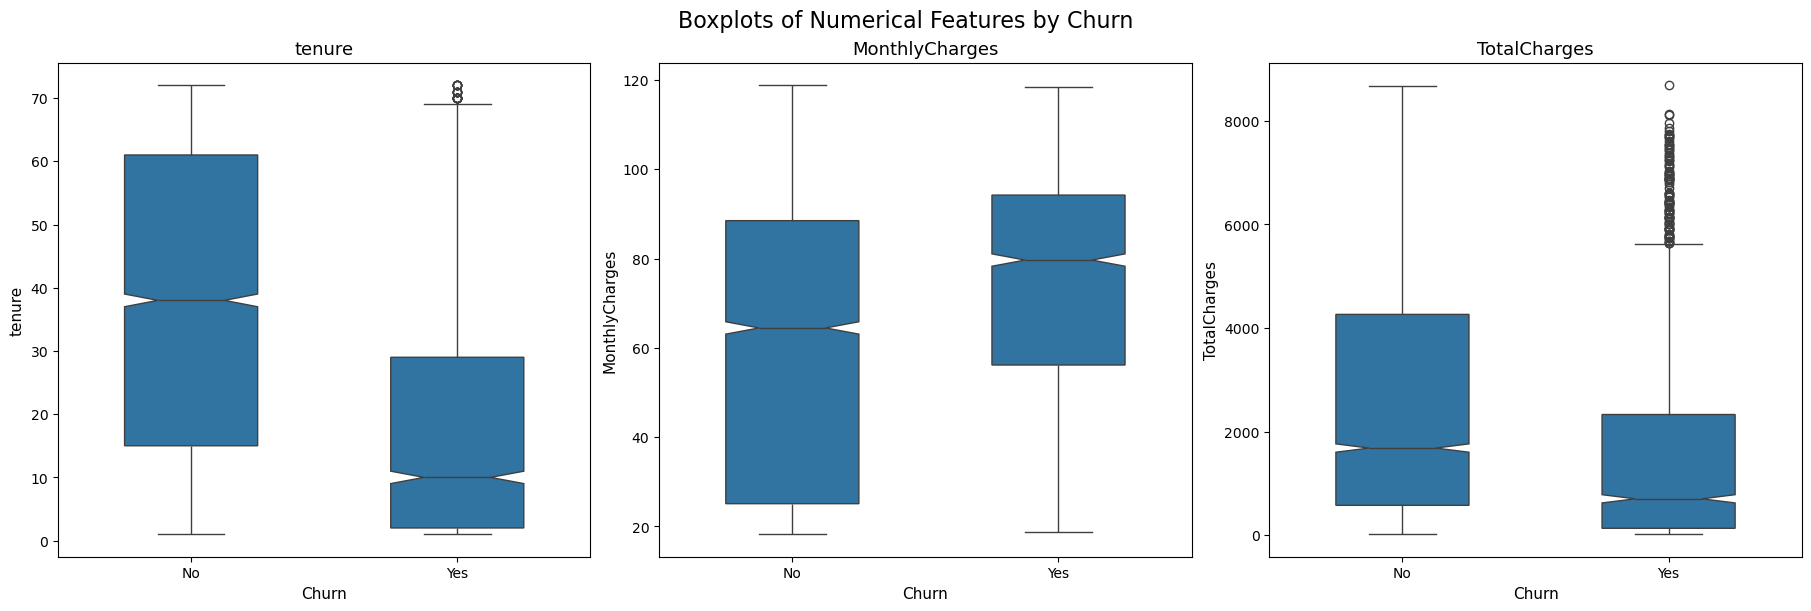

In [24]:
fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6), constrained_layout=True)

# Loop over numeric features
for i, col in enumerate(numeric_features):
    sns.boxplot(data=df, y=col, x='Churn', ax=axes[i], width=0.5, notch=True)
    axes[i].set_title(f"{col}", fontsize=13)
    axes[i].set_xlabel(TARGET_COLUMN, fontsize=11)
    axes[i].set_ylabel(col, fontsize=11)
    axes[i].tick_params(labelsize=10)

# Add main title
fig.suptitle("Boxplots of Numerical Features by Churn", fontsize=16)

plt.show()

The boxplots clearly show different patterns in the numerical features based on churn status. Customers who did not churn have a much higher median `tenure` compared to those who churned, meaning loyal customers tend to stay longer. In contrast, customers who churned often have very short tenure, suggesting that many leave early in their contract period.

For `MonthlyCharges`, customers who churn generally pay more on average than those who stay. This could suggest that higher monthly costs may lead to dissatisfaction or affordability issues. The `TotalCharges` feature also shows a strong difference. Since it is the product of tenure and monthly charges, it makes sense that customers who churn have much lower total charges. This supports the idea that they often leave early. Overall, these numerical features provide useful signals for predicting churn.


To better understand the numerical features, Let's also look at the histogram with KDE (Kernel Density Estimate) for each numerical feature. This will help us visualize the distribution of values and identify any skewness or unusual patterns.

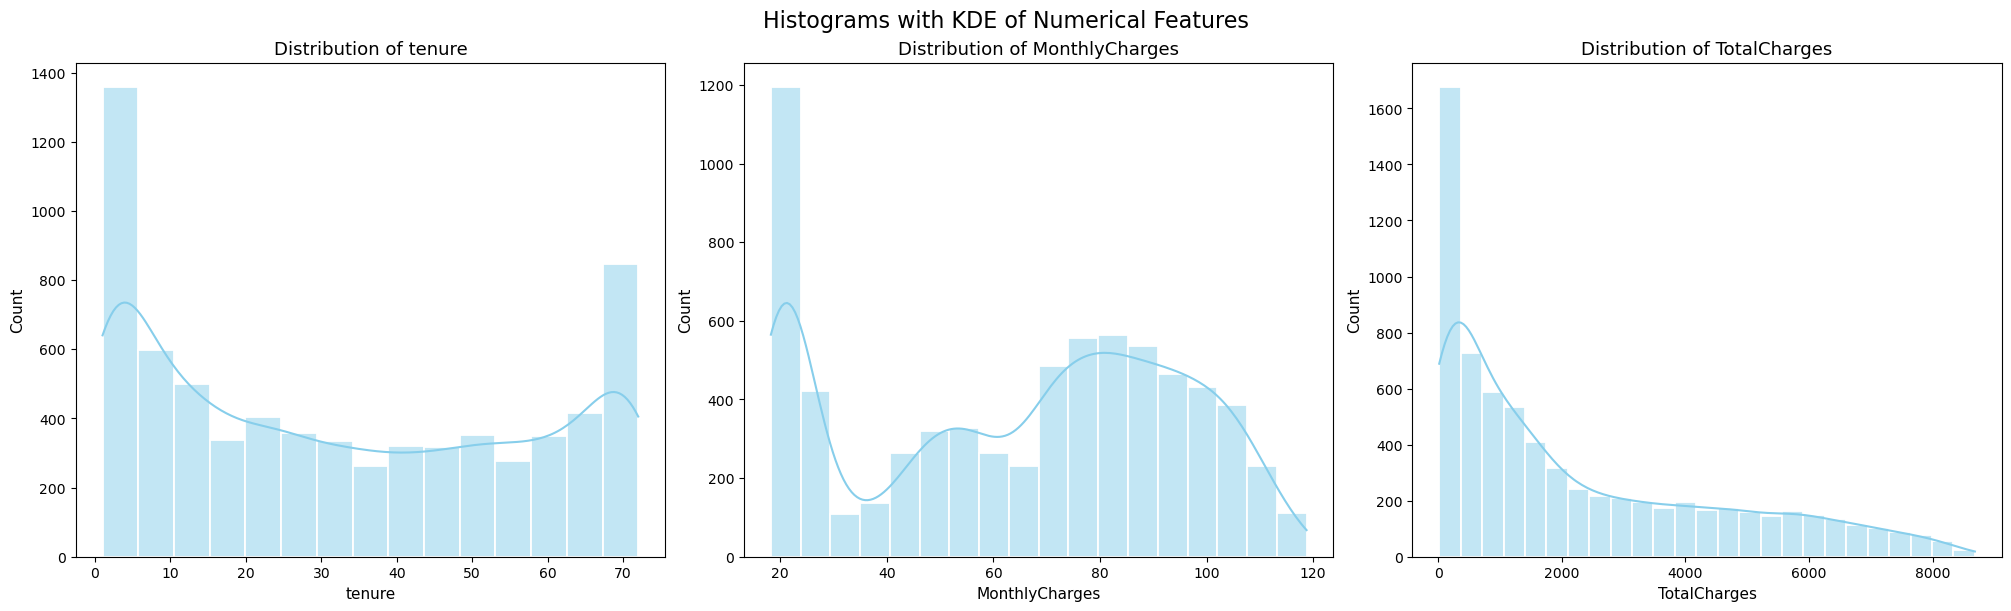

In [25]:
fig, axes = plt.subplots(1, len(numeric_features), figsize=(20, 6), constrained_layout=True)

for i, col in enumerate(numeric_features):
    sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", edgecolor="white", linewidth=1.3)
    axes[i].set_title(f"Distribution of {col}", fontsize=13)
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel("Count", fontsize=11)
    axes[i].tick_params(labelsize=10)

fig.suptitle("Histograms with KDE of Numerical Features", fontsize=16)
plt.show()

The histograms with KDE curves provide a deeper view of how the numerical features are distributed. The `tenure` variable shows a bimodal pattern, with many customers at the beginning (around 0–10 months) and another peak around 70 months. This suggests that some customers leave very early, while others tend to stay for many years.

The `MonthlyCharges` feature appears roughly right-skewed, with a concentration of customers around 70–90. However, there is also a significant number of customers paying less than 30. The `TotalCharges` variable is strongly right-skewed, which makes sense since it accumulates over time based on both tenure and monthly charges. Many customers have relatively low total charges, likely due to short tenure. These distributions confirm that feature scaling or transformations might be useful before modeling.


Next step, we use `sns.pairplot` to visualize the relationships between numerical features and the target variable `Churn`. This will help us see how these features interact with each other and with churn.

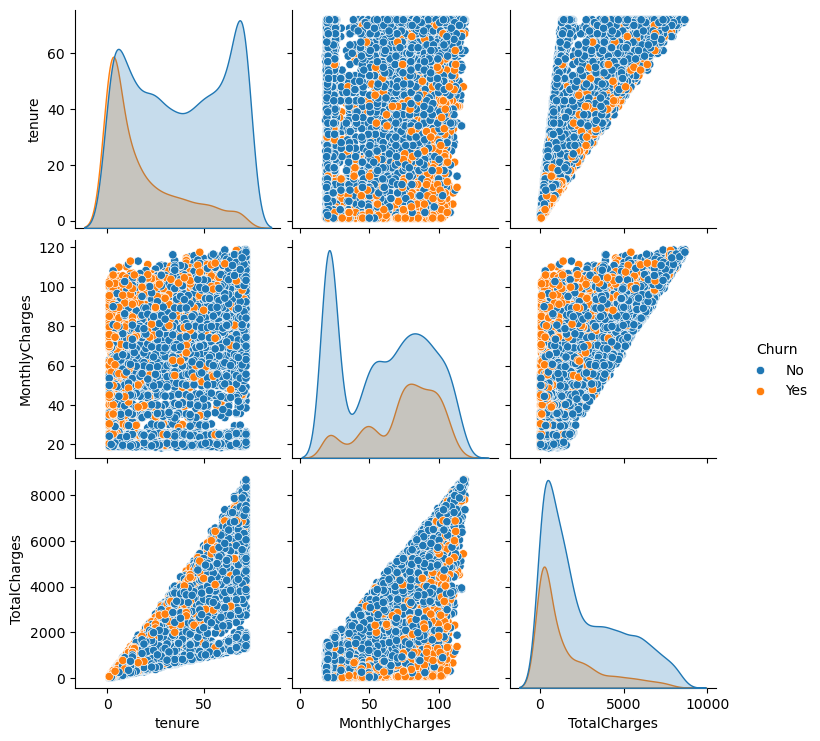

In [26]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')

The pairplot shows the relationships between `tenure`, `MonthlyCharges`, and `TotalCharges`, colored by churn status. We can observe that customers who churned (orange) tend to have lower `tenure` and lower `TotalCharges`, but often have higher `MonthlyCharges`. This supports earlier findings that customers who leave usually do so early and may be paying more per month.

There is also a strong positive linear relationship between `tenure` and `TotalCharges`, which is expected since longer-tenure customers accumulate higher total charges. The density plots along the diagonal show clear separation between churned and non-churned customers, especially in `tenure` and `TotalCharges`. Overall, this plot confirms that these numerical features are useful for distinguishing between churned and retained customers.


Now, let's analyze the correlation matrix for the numerical features, including the target variable `Churn`. This will help us quantify the relationships between these features and identify any strong correlations.

<Axes: >

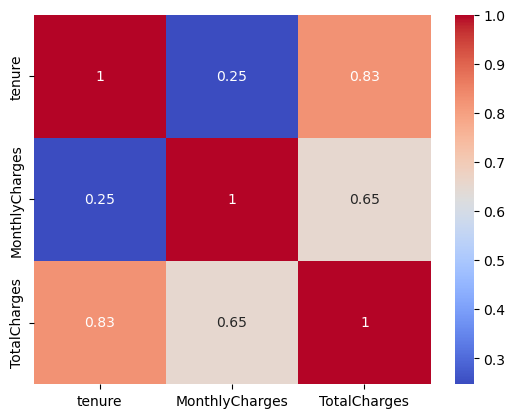

In [27]:
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

This correlation matrix focuses only on continuous numerical features: `tenure`, `MonthlyCharges`, and `TotalCharges`. The strongest correlation is between `tenure` and `TotalCharges` (0.83), which is expected since the total charges accumulate over time. There is also a moderate positive correlation between `MonthlyCharges` and `TotalCharges` (0.65), showing that customers with higher monthly fees tend to have higher total charges.

The correlation between `tenure` and `MonthlyCharges` is relatively weak (0.25), suggesting that the monthly rate does not strongly depend on how long a customer stays. Overall, this heatmap confirms that `TotalCharges` is influenced by both other features, and that `tenure` and `MonthlyCharges` each contribute useful, but different, information to churn prediction.


#### VIF Analysis

To get a better insight into the correlation of features, let's take a look at the VIF (Variance inflaction factor) of the features. VIP helps us to identify multicollinearity among features. A high VIF indicates that a feature is highly correlated with other features, which can lead to issue in model training.

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert target to binary
df[TARGET_COLUMN] = df[TARGET_COLUMN].map({"Yes": 1, "No": 0})

# Define target and numeric features (exclude TotalSpendEstimate)
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']  # No TotalSpendEstimate

# Prepare X matrix
X = df[numeric_features].copy()
X['Intercept'] = 1  # Add intercept for VIF computation

# Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop intercept from results (optional)
vif_data = vif_data[vif_data['Feature'] != 'Intercept']

print(vif_data)


          Feature       VIF
0          tenure  5.844646
1  MonthlyCharges  3.225293
2    TotalCharges  9.526697


To further investigate multicollinearity, we calculated the Variance Inflation Factor (VIF) for the three numerical features. The results show that `TotalCharges` has a high VIF value of 9.53, indicating strong multicollinearity with other features. This makes sense given that `TotalCharges` is closely related to both `tenure` and `MonthlyCharges`.

In contrast, `tenure` and `MonthlyCharges` have lower VIF values of 5.84 and 3.23, which are within acceptable ranges. These findings suggest that if we use linear models like logistic regression, it may be beneficial to drop `TotalCharges` to avoid instability caused by multicollinearity. However, for tree-based models like Random Forest, all features can be safely included.

#### Summary of Numerical Feature Significance

Based on the exploratory analysis, including boxplots, distribution plots, pairplots, and correlation matrix, we can draw conclusions about the significance of the numerical features in relation to the target variable `Churn`.

The feature `tenure` appears to be the most significant indicator of churn. Customers who churn tend to have much shorter tenure, suggesting they leave early in their customer lifecycle. This is clearly visible in both the boxplots and pairplots, where churned customers are concentrated at low tenure values.

`MonthlyCharges` also shows a moderate association with churn. Customers who churn are more likely to be paying higher monthly fees, which might indicate dissatisfaction or affordability issues. Although the relationship is weaker than with tenure, it still adds meaningful information.

On the other hand, `TotalCharges` is highly correlated with `tenure` (correlation coefficient ≈ 0.83) and is largely derived from it. While it does reflect overall customer spending, it may not add much independent value for churn prediction and could introduce multicollinearity if used alongside `tenure`.

To verify this, we computed the Variance Inflation Factor (VIF) for each feature. The VIF score for `TotalCharges` was 9.53—close to the commonly used threshold of 10—indicating a high degree of multicollinearity. In contrast, `tenure` and `MonthlyCharges` had acceptable VIF values of 5.84 and 3.23, respectively. This supports the conclusion that `tenure` and `MonthlyCharges` should be prioritized, and `TotalCharges` should be excluded from linear models or used cautiously depending on the modeling technique.

In conclusion, `tenure` and `MonthlyCharges` are significant numerical features for predicting churn, while `TotalCharges` shows redundancy and multicollinearity risk that may affect certain models.


### Categorical Features Analysis


For categorical features, we first plot the distribution of each feature based on their values (categories) and then analyze their correlation with the target variable `Churn`. We will use count plots for categorical features and a bar plot for the correlation analysis. Let's start with the count plots for each categorical feature.

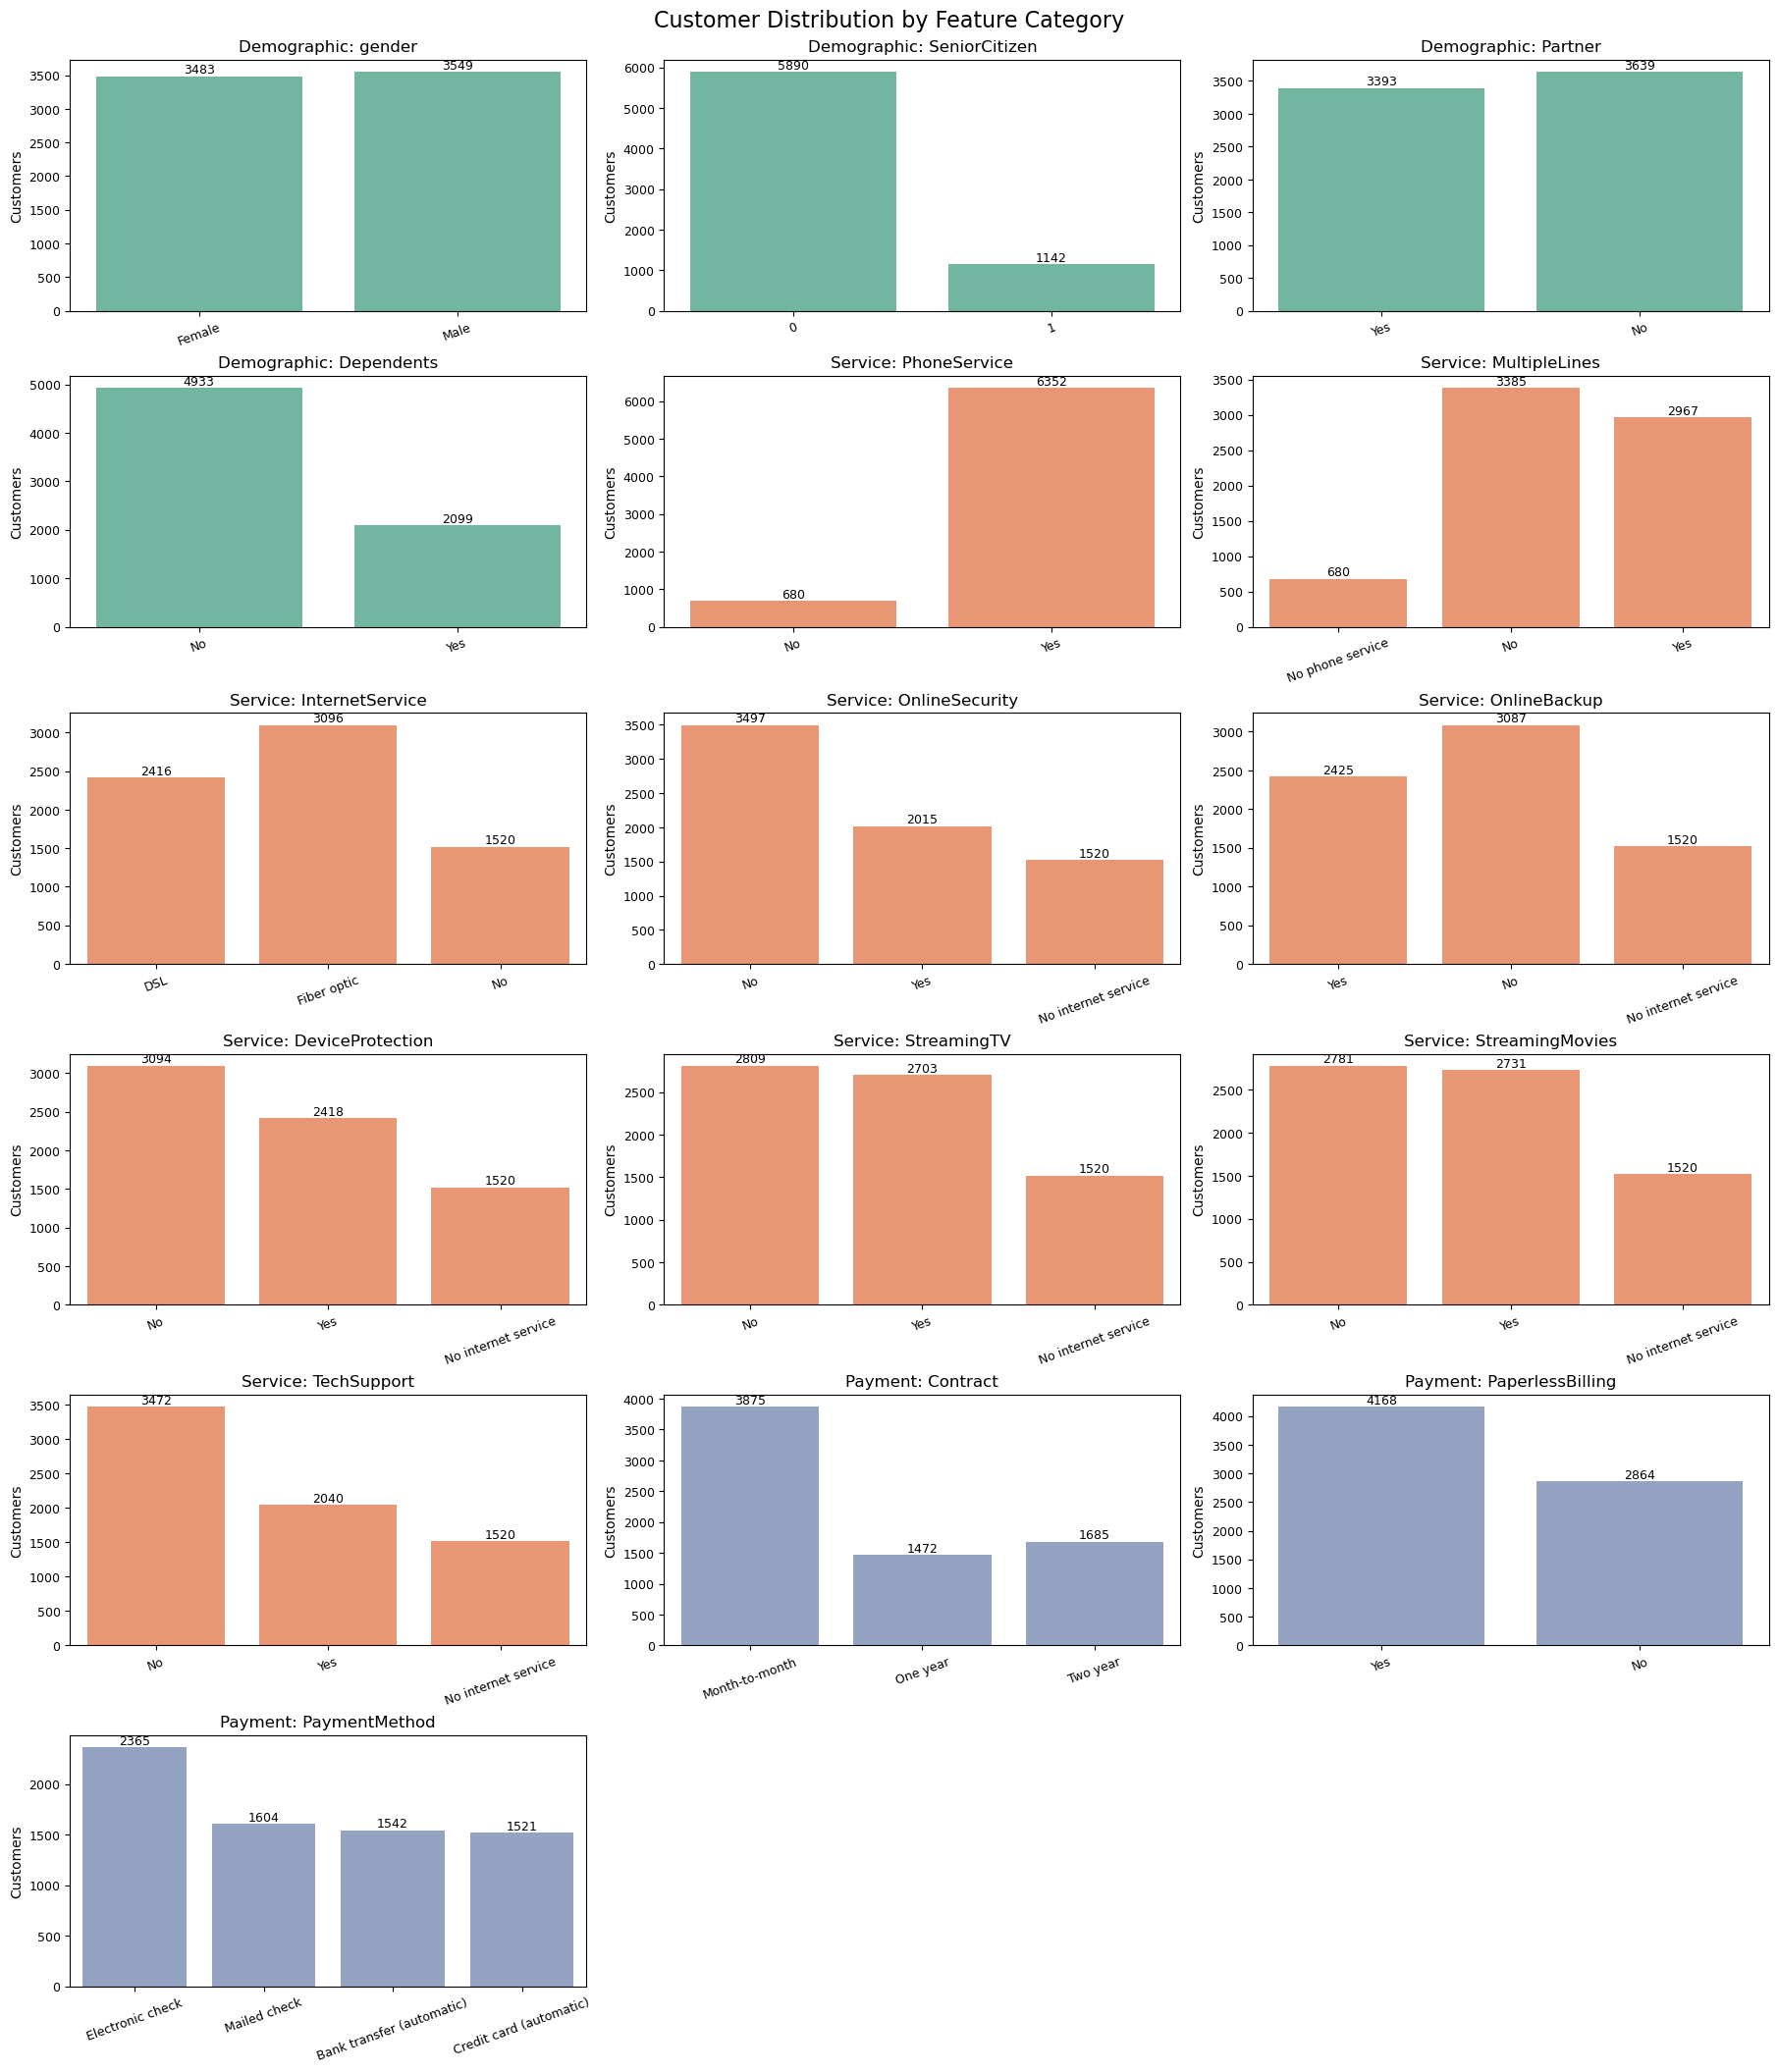

In [29]:
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
feature_categories = (
    ['Demographic'] * len(demographic_features) +
    ['Service'] * len(service_features) +
    ['Payment'] * len(payment_features)
)
category_colors = {
    'Demographic': sns.color_palette("Set2")[0],
    'Service': sns.color_palette("Set2")[1],
    'Payment': sns.color_palette("Set2")[2]
}
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 3.5), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    category = feature_categories[i]
    sns.countplot(x=df[feature], ax=ax, color=category_colors[category])
    ax.bar_label(ax.containers[0], fontsize=9)
    ax.set_title(f"{feature_categories[i]}: {feature}", fontsize=12)
    ax.set_ylabel("Customers", fontsize=10)
    ax.set_xlabel("", fontsize=10)
    ax.tick_params(axis='x', labelrotation=20, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

for j in range(len(features), len(axes)):
    axes[j].axis('off')

fig.suptitle("Customer Distribution by Feature Category", fontsize=16)
plt.show()


The count plots show how the values of each categorical feature are distributed. The demographic features are quite balanced. For example, the number of male and female customers is similar. Most customers are not senior citizens and do not have dependents.

For the service-related features, we see that many customers have phone service and internet. However, fewer people use services like tech support, device protection, or online security. These services might affect whether a customer stays or leaves. In the payment features, most customers have month-to-month contracts and use electronic checks. These choices may be related to a higher risk of churn because short contracts and certain payment types often mean lower customer loyalty.

These plots help us understand the data better and will guide the analysis of how these features relate to churn in the next step.


Now let's analyze the correlation of these categorical features with the target variable `Churn`. We will use a bar plot to visualize the correlation coefficients for each feature with respect to churn.

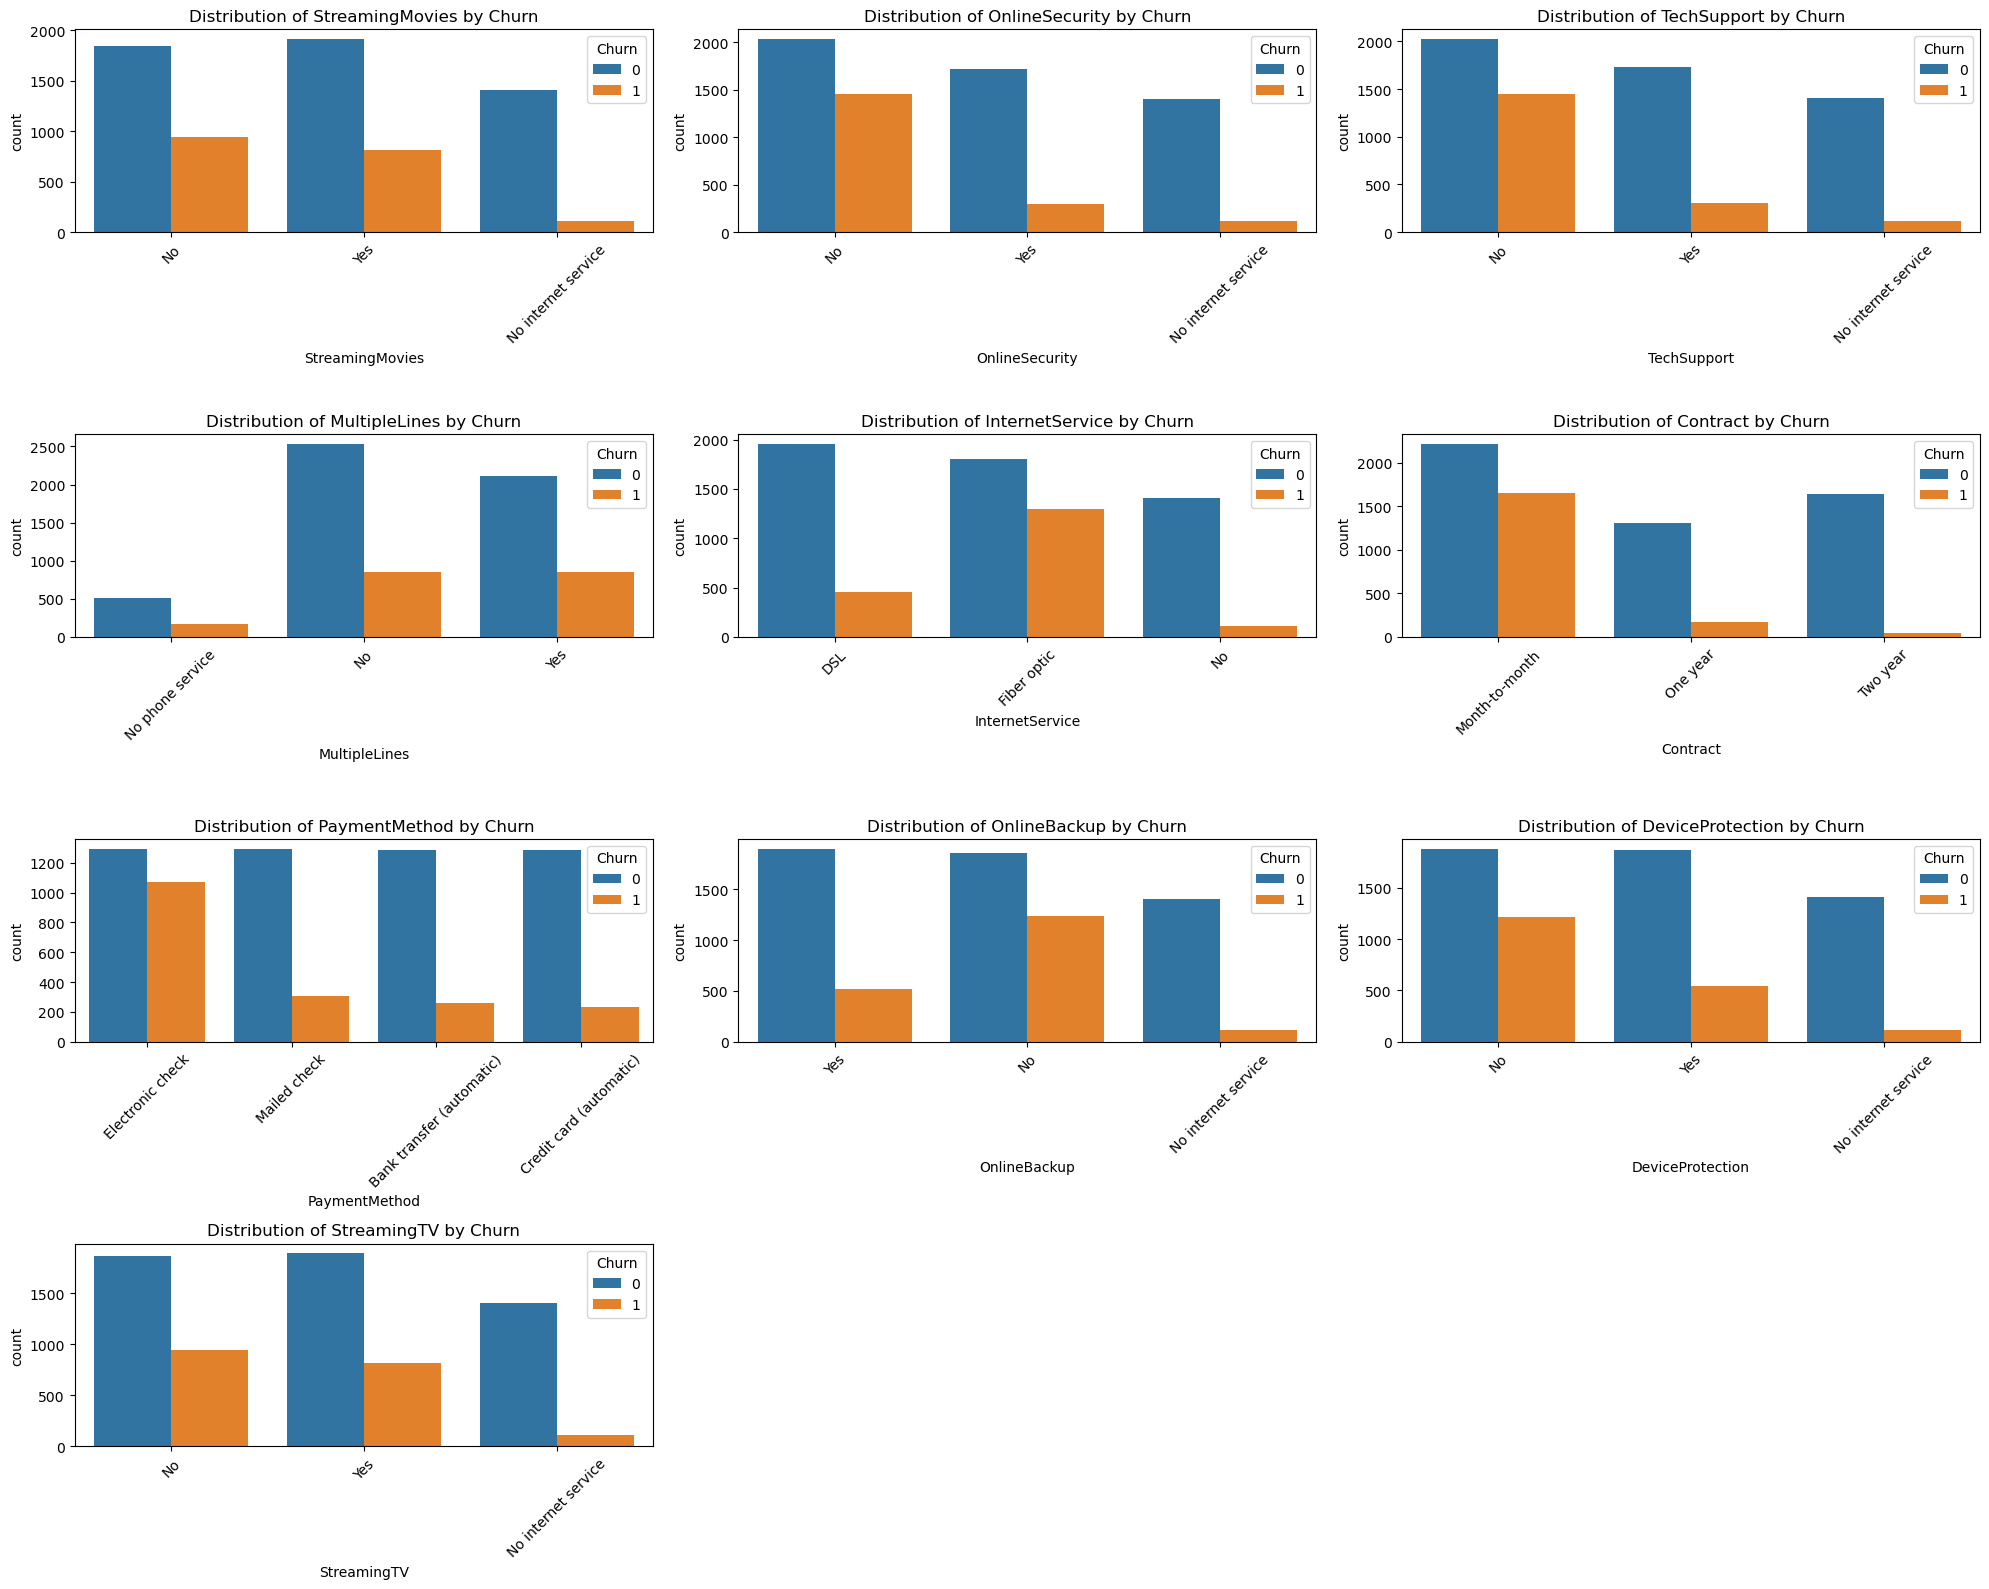

In [30]:
n_cols = 3
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Churn')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

From the grouped count plots, we can observe how different categories relate to the target variable `Churn`. Some features show a clear difference between customers who churned and those who did not.

For example, customers on **month-to-month contracts** show a much higher churn rate compared to those with one- or two-year contracts. This suggests that customers with flexible plans are more likely to leave. Similarly, people who use **electronic check** as their payment method also have higher churn, while customers who use credit cards or bank transfers tend to stay longer.

Service-related features like **OnlineSecurity**, **TechSupport**, and **DeviceProtection** also show strong patterns: churn is higher among those who do not use these services. This may indicate that customers who feel less supported or protected are more likely to leave. In contrast, for features like **StreamingTV** or **StreamingMovies**, the churn rates are more balanced across categories, meaning they might not be strong predictors of churn.

Overall, contract type, payment method, and use of support-related services appear to have the strongest correlation with churn.


## Data Preprocessing

We have completed the EDA and identified the features that are significant for predicting churn. Now, we need to preprocess the data to prepare it for modeling. Some of the analysis are only possible after preprocessing, such as encoding categorical variables and scaling numerical features. So let's proceed with the preprocessing steps and then re-evaluate the data.

Dataset has binary, categorical, and numerical features. We will handle each type appropriately:
1. **Binary Features**: Convert binary features to numerical values (0 and 1).
2. **Categorical Features**: Use one-hot encoding for categorical features with more than two categories.
3. **Numerical Features**: Scale numerical features to have zero mean and unit variance.
We will use `pd.get_dummies` for one-hot encoding categorical features and `StandardScaler` for scaling numerical features. Let's implement these preprocessing steps.

In order to have a reusable code, we will create `load_and_preprocess` function that loads the dataset and preprocess it based on the parameters passed to it. This is necessary because we will also use some model that doesn't required preprocessing, such as `CatBoostClassifier`, which can handle categorical features directly. 

Here are the steps we will take in the `load_and_preprocess` function:
1. Load the dataset from the give path.
2. drop the `customerID` column as it has no predictive value.
3. Convert `TotalCharges` to numeric and drop rows with `NaN` values.
4. Encode binary features to numerical values (0 and 1)
5. encode target variable `Churn` to numerical values (0 and 1).
6. Map gender to 0 and 1.
7. one-hot encode categorical features with more than two categories.
8. Scale numerical features using `StandardScaler`.

In [31]:
def load_and_preprocess(
    filepath: str,
    drop_aux=False,
    encode_binary=False,
    map_gender=False,
    one_hot_encoding=False,
    scale_numeric=False,
    to_numeric=False,
    encode_target=True,
) -> pd.DataFrame:
    churn_df = pd.read_csv(filepath)
    if drop_aux:
        # Drop customerID
        churn_df = churn_df.drop(columns=["customerID"])

    if to_numeric:
        # Convert TotalCharges to numeric and drop missing values
        churn_df["TotalCharges"] = pd.to_numeric(
            churn_df["TotalCharges"], errors="coerce"
        )
        churn_df = churn_df.dropna(subset=["TotalCharges"])

    if encode_binary:
        # Encode binary features
        binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
        for col in binary_cols:
            churn_df[col] = churn_df[col].map({"Yes": 1, "No": 0})

    if encode_target:
        # Encode target variable
        churn_df[TARGET_COLUMN] = churn_df[TARGET_COLUMN].map({"Yes": 1, "No": 0})

    if map_gender:
        # Map gender
        churn_df["gender"] = churn_df["gender"].map({"Male": 1, "Female": 0})

    if one_hot_encoding:
        # One-hot encode remaining categorical variables
        categorical_cols = churn_df.select_dtypes(include=["object"]).columns.tolist()
        churn_df = pd.get_dummies(churn_df, columns=categorical_cols, drop_first=True)

    if scale_numeric:
        # Scale numeric features
        numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
        scaler = StandardScaler()
        churn_df[numeric_cols] = scaler.fit_transform(churn_df[numeric_cols])

    return churn_df

In [32]:
df = load_and_preprocess(DATASET_PATH, drop_aux=True, encode_binary=True, map_gender=True, one_hot_encoding=True, scale_numeric=True, to_numeric=True, encode_target=True)

### Correlation of All Features with Target Variable

Now that we have preprocessed the data, let's analyze the correlation of all features with the target variable `Churn`. This will help us understand which features are most relevant for predicting churn. 

Note: Since heatmap can be hard to read, especially after adding dummy variables, we use a bar plot to visualize the correlation coefficient for each feature with respect to churn.


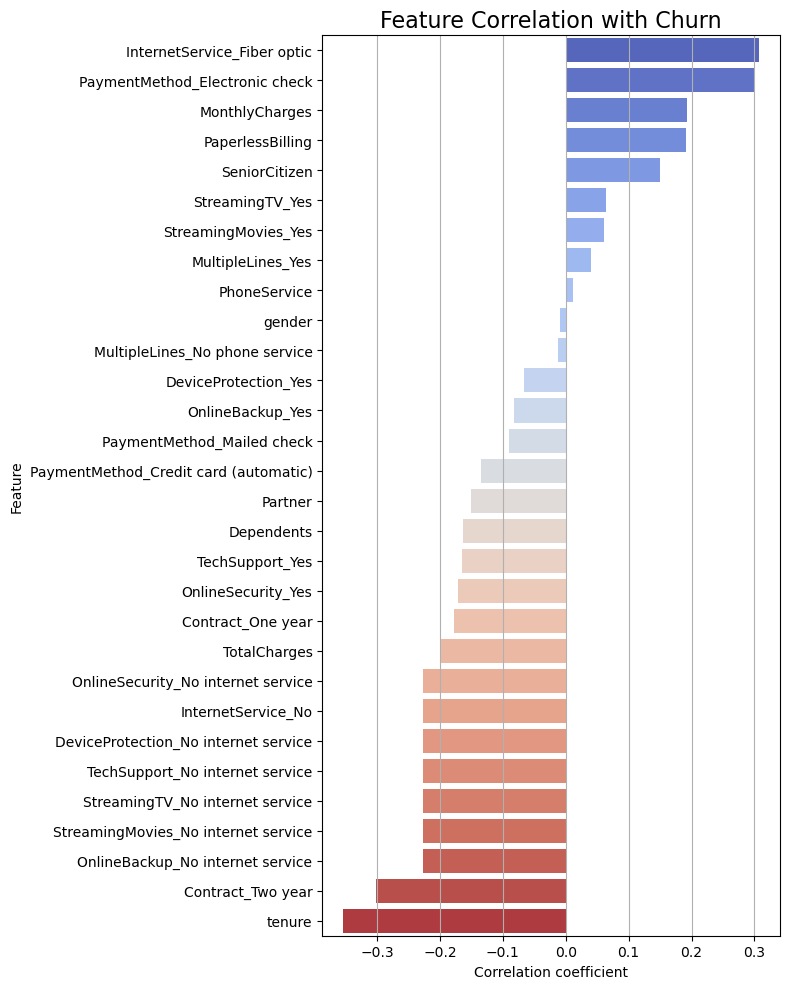

In [33]:
churn_corr = df.corr(numeric_only=True)['Churn'].drop('Churn').sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x=churn_corr.values, y=churn_corr.index, hue=churn_corr.index,
            palette="coolwarm", legend=False)
plt.title("Feature Correlation with Churn", fontsize=16)
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


This bar plot shows how each feature is related to the target variable `Churn`. Features like `InternetService_Fiber optic` and `PaymentMethod_Electronic check` have the strongest positive correlations, meaning customers with these characteristics are more likely to leave. In contrast, features such as `Contract_Two year` and `tenure` show a negative correlation, suggesting these customers are more likely to stay.

Many features have very low or near-zero correlation with churn. This doesn’t mean they are unimportant—it just means they may not have a simple linear relationship with the target. This plot adds to the earlier correlation analysis of numerical features and helps us understand which variables might be more useful for predicting churn.

In summary, the correlation analysis reveals that customers with **fiber optic internet**, **electronic check payment**, and **higher monthly charges** are more likely to churn. In contrast, customers with **longer tenure**, **two-year contracts**, and **value-added services** like *Tech Support* and *Online Security* show lower churn rates. These patterns highlight which features are most predictive and will inform our feature selection and model design.


## Model Assessment

### Model Selection

We will assess the performance of various classification models on the churn prediction tasks. The models we will evaluate include:
1. **Logistic Regression**: A simple linear model for binary classification.
2. **Random Forest**: An ensemble method that builds multiple decision trees.
3. **Support Vector Machine**: A powerful model that finds the optimal hyperplane for classification.

And we will also evaluate the **CatBoostClassifier**, which is outside of the course syllabus but is a powerful model for categorical data and can handle categorical features directly without preprocessing.

### Evaluation Metrics

We will use the following evaluation metrics to assess model performance:
1. Accuracy: The proportion of correct predictions out of total predictions.
2. Precision: The proportion of true positive predictions out of all positive predictions.
3. Recall: The proportion of true positive predictions out of all actual positive cases.
4. F1_Score: The harmonic mean of precision and recall, providing a balance between the two.
5. roc_auc: The area under the ROC curve, which measures the model's ability to distinguish between classes.
6. Confusion Matrix: A table that summarizes the performance of the classification model by showing true positives, true negatives, false positives, and false negatives.

In [34]:
df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=True,
    map_gender=True,
    one_hot_encoding=True,
    scale_numeric=True,
    to_numeric=True,
)
results = {}

### Handling Class Imbalance with SMOTE

In our dataset, the target variable **Churn** is moderately imbalanced, with approximately **73% non-churn** and **27% churn** cases. This imbalance can lead to biased model performance, where classifiers favor the majority class (non-churn) and fail to correctly identify minority class instances (churned customers). Such a bias is especially problematic in churn prediction tasks, where identifying customers at risk of leaving is crucial for business actions.

To address this, I employed **SMOTE** on the training data. SMOTE works by creating synthetic examples of the minority class based on the feature space similarities between existing minority samples. This method helps balance the dataset without simply duplicating existing instances.

We applied SMOTE **only to the training set** to avoid data leakage and then retrained all models using the oversampled data. <span style="color: orange">The evaluation was still performed on the original test set to ensure fair comparison.</span>

### Using Pipeline for Preprocessing and Model Training

To streamline the preprocessing and model training process, we will use `Pipeline` from `imblearn`. This allows us to combine preprocessing steps (like scaling and SMOTE) with model training in a single workflow. The pipeline will ensure that all preprocessing is applied consistently to both training and test data.

### Hyperparameter Tuning

For each model, we will perform hyperparameter tuning using `GridSearchCV` to find the best parameters that maximize the evaluation metrics. 

For scoring the models, Considering our target variable is imbalanced, we will use `roc_auc` as the scoring metric. This metric is suitable for imbalanced datasets as it evaluates the model's ability to distinguish between classes across all thresholds, rather than just at a single point.

### K-Fold Cross-Validation

To ensure robust model evaluation, we will use K-Fold cross-validation. This technique splits the dataset into K subsets (folds) and trains the model K times, each time using a different fold as the test set and the remaining folds as the training set. This helps us get a more reliable estimate of model performance by averaging results across multiple splits.
We use 5-fold cross-validation for all models, which is a common choice that balances computational efficiency and reliability.

First, let's create or train-test split, using `train_test_split` from `sklearn.model_selection`. We will use 80% of the data for training and 20% for testing. We will also set a random seed for reproducibility.

In [35]:
y = df[TARGET_COLUMN]
X = df.drop(columns=[TARGET_COLUMN])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

### Logistic Regression

We will start with Logistic Regression, which is a simple yet effective model for binary classification tasks. We will use `LogisticRegression` from `sklearn.linear_model` and apply it within a pipeline that includes scaling and SMOTE.
For hyperparameter tuning, we will use `GridSearchCV` to find the best parameters for the model. The parameters we will tune include:
- `C`: Inverse of regularization strength (default is 1.0)
- `penalty`: Type of regularization to apply (default is 'l2')
- `max_iter`: Maximum number of iterations for convergence (default is 100)

In [36]:
lr_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, solver="liblinear"))
])

lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__max_iter': [100, 200, 300, 500, 1000]
}

lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=K_FOLDS,
    scoring=SCORING,
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train, y_train)
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l1'}


After training the model, we will evaluate its performance. We store the evaluation metrics in a dictionary for easy comparison later. Also, we will store some additional information about the model, such as the best parameters, confusion matrix, `fpr`, `tpr`, and `roc_auc` which will be used for plotting the ROC curve.

In [37]:
# Evaluation of the model
lr_y_pred = lr_grid_search.predict(X_test)

lr_y_proba = lr_grid_search.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_proba)
lr_roc_auc = roc_auc_score(y_test, lr_y_proba)

results["Logistic Regression"] = {
    "values": {
        "accuracy": accuracy_score(y_test, lr_y_pred),
        "precision": precision_score(y_test, lr_y_pred),
        "recall": recall_score(y_test, lr_y_pred),
        "f1": f1_score(y_test, lr_y_pred),
        "roc_auc": roc_auc_score(y_test, lr_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": lr_fpr,
        "tpr": lr_tpr,
        "roc_auc": lr_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, lr_y_pred),
    "model": lr_grid_search.best_estimator_,
    "params": lr_grid_search.best_params_,
}
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



### Support Vector Machine Classifier

Next we will evaluate the Support Vector Machine (SVM) classifier using `SVC` from `sklearn.svm`. We will also use a pipeline that includes scaling and SMOTE.

We use `GridSearchCV` to tune the hyperparameters of the SVM model. The parameters we will tune include:
- `C`: Regularization parameter (default is 1.0)
- `kernel`: Type of kernel to use (default is 'rbf')
- `gamma`: Kernel coefficient (default is 'scale')

<span style="color: orange">Note:</span> We don't use `poly` kernel for SVM, it causes the model to take too long to train, even with a small dataset like this one. We tested it (it took more than 20 minutes to train) and it didn't improve the performance and the best parameters were the same as the `linear` kernel. So we will stick with the `rbf` and `linear` kernels for our hyperparameter tuning.

Here's the best parameters using `GridSearchCV` including `poly` kernel with `degree=[2,3,4]`


```python
svm_params = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__degree': [2, 3, 4],
    'clf__gamma': ['scale', 'auto']
}
## Output
{'clf__C': 0.1, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
```

In [38]:
svm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, random_state=RANDOM_STATE))
])

svm_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}
svm_grid_search = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=K_FOLDS,
    scoring=SCORING,
    n_jobs=-1,
    verbose=1
)
svm_grid_search.fit(X_train, y_train)
print("Best parameters:", svm_grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


In [39]:
svm_y_pred = svm_grid_search.predict(X_test)

svm_y_proba = svm_grid_search.predict_proba(X_test)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_proba)
svm_roc_auc = roc_auc_score(y_test, svm_y_proba)

results["SVM"] = {
    "values": {
        "accuracy": accuracy_score(y_test, svm_y_pred),
        "precision": precision_score(y_test, svm_y_pred),
        "recall": recall_score(y_test, svm_y_pred),
        "f1": f1_score(y_test, svm_y_pred),
        "roc_auc": roc_auc_score(y_test, svm_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": svm_fpr,
        "tpr": svm_tpr,
        "roc_auc": svm_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, svm_y_pred),
    "model": svm_grid_search.best_estimator_,
    "params": svm_grid_search.best_params_,
}
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.75      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407



### Random Forest Classifier
Next, we will evaluate the Random Forest classifier using `RandomForestClassifier` from `sklearn.ensemble`. We will also use a pipeline that includes scaling and SMOTE.
We will use `GridSearchCV` to tune the hyperparameters of the Random Forest model. The parameters we will tune include:
- `n_estimators`: Number of trees in the forest (default is 100)
- `max_depth`: Maximum depth of the tree (default is None)
- `min_samples_split`: Minimum number of samples required to split an internal node (default is 2)
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node (default is 1)


In [40]:
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])
rf_param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=K_FOLDS,
    scoring=SCORING,
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l1'}


In [41]:
# Evaluation of Random Forest Classifier
rf_y_pred = rf_grid_search.predict(X_test)

rf_y_proba = rf_grid_search.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_proba)
rf_roc_auc = roc_auc_score(y_test, rf_y_proba)

results["Random Forest"] = {
    "values": {
        "accuracy": accuracy_score(y_test, rf_y_pred),
        "precision": precision_score(y_test, rf_y_pred),
        "recall": recall_score(y_test, rf_y_pred),
        "f1": f1_score(y_test, rf_y_pred),
        "roc_auc": roc_auc_score(y_test, rf_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": rf_fpr,
        "tpr": rf_tpr,
        "roc_auc": rf_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, rf_y_pred),
    "model": rf_grid_search.best_estimator_,
    "params": rf_grid_search.best_params_,
}
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.72      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.78      0.74      0.75      1407



#### Random Forest Feature Importance

A cool feature of Random Forest is its ability to provide feature importance scores. These scores indicate how much each feature contributes to the model's predictions. We can visualize the feature importances using a bar plot.

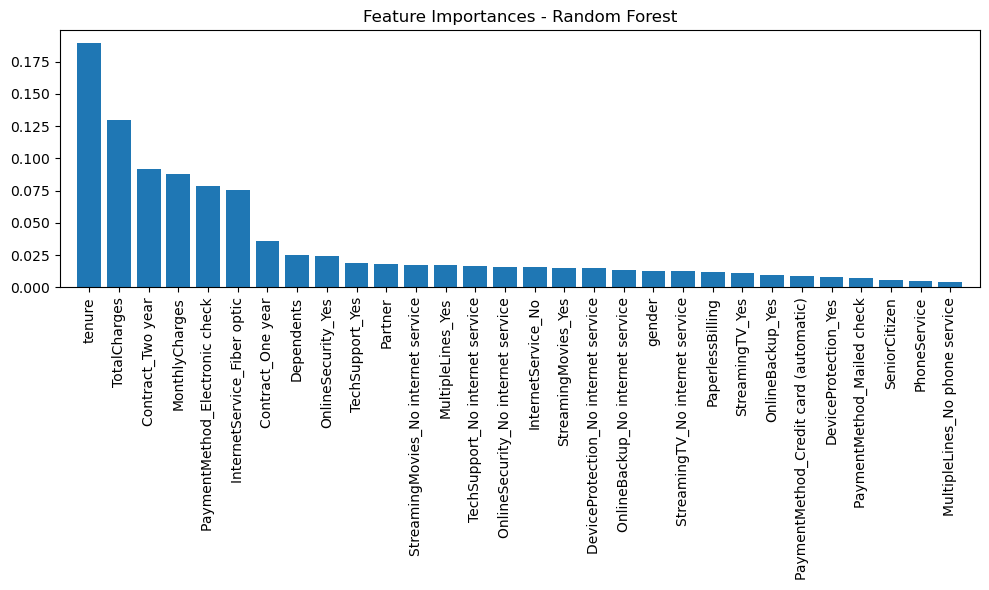

In [42]:
# Feature importance for Random Forest
importances = rf_grid_search.best_estimator_.named_steps['clf'].feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

The plot shows `tenure`, `TotalCharges`, and `MonthlyCharges` as the top three most important features for predicting churn. This aligns with our earlier analysis, confirming that these numerical features are indeed significant predictors. `Contract_Two year` also has a high importance score, which is also aligns with our earlier findings that customers with longer contracts are less likely to churn. Other features like `PaymentMethod_Electronic check`, and `InternetService_Fiber optic` also contribute to the model's predictions, but to a lesser extent.

### CatBoost Classifier
Finally, we will evaluate the CatBoost classifier using `CatBoostClassifier` from the `catboost` library. CatBoost is a gradient boosting algorithm that can handle categorical features directly without the need for one-hot encoding or label encoding.
For CatBoost, we don't need to use pipelines or scaling, as it can handle categorical features natively.

We will have two steps of hyperparameter tuning:
1. Using `cv` to find find the best estimate for iterations. Iterations is the number of boosting iterations, which is a crucial hyperparameter for CatBoost.
2. Using `GridSearchCV` to tune the hyperparameters of the CatBoost model. The parameters we will tune include:
- `depth`: Depth of the tree (default is 6)
- `learning_rate`: Learning rate for boosting (default is 0.03)
- `l2_leaf_reg`: L2 regularization coefficient (default is 3)
- `early_stopping_rounds`: Number of rounds to stop training if no improvement (default is 50)

For CatBoost, we also need to specify the categorical features in the model. We will use the `categorical_features` parameter to specify the categorical features in the dataset.

#### Train and Test Pool
We will create a `Pool` for training and testing data, which is a special data structure used by CatBoost to handle categorical features efficiently. The `Pool` will contain the training and testing data along with the target variable.

<span style="color: orange">Note:</span> Since CatBoost can handle categorical features directly, we don't need to preprocess the data like we did for other models. We will still use `load_and_preprocess` function to load the data, but we will not apply one-hot encoding or scaling for CatBoost.

#### Using class-weight in CatBoost

To handle class imbalance in CatBoost, we can use the `class_weights` parameter. This parameter allows us to assign different weights to each class, which helps the model pay more attention to the minority class (churned customers). We will set the weight for the churned class to be higher than the non-churned class.
For this example, I calculated the class weight manually based on the distribution of the target variable. The weight for the churned class is set to `[0.68, 1.88]`, which means the churned class will be given more importance during training.

In [43]:
cb_df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=False,
    map_gender=False,
    one_hot_encoding=False,
    scale_numeric=False,
    to_numeric=True,
    encode_target=True,
)

categorical_features = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

cb_X = cb_df.drop(columns=[TARGET_COLUMN])
cb_y = cb_df[TARGET_COLUMN]

cb_X_train, cb_X_test, cb_y_train, cb_y_test = train_test_split(cb_X, cb_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)


In [44]:
train_pool = Pool(cb_X_train, cb_y_train, cat_features=categorical_features)
test_pool = Pool(cb_X_test, cb_y_test, cat_features=categorical_features)

In [45]:
cb_cv_param_grid = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": RANDOM_STATE,
    "verbose": False,
    "iterations": 1000,
    "early_stopping_rounds": 50,
}
cv_results = cv(
    params=cb_cv_param_grid,
    pool=train_pool,
    fold_count=K_FOLDS,
    partition_random_seed=RANDOM_STATE,
    verbose=False,
    plot=True,
)
best_iteration = cv_results['iterations'].max()
print(f"Best Iteration: {best_iteration}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8493444654
bestIteration = 164

Training on fold [1/5]

bestTest = 0.8431454323
bestIteration = 162

Training on fold [2/5]

bestTest = 0.8523447812
bestIteration = 239

Training on fold [3/5]

bestTest = 0.8456983326
bestIteration = 320

Training on fold [4/5]

bestTest = 0.8599690656
bestIteration = 232

Best Iteration: 370


In [46]:
cb_param_grid = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5],
    "early_stopping_rounds": [10, 50, 100],
}
cb_classifier = CatBoostClassifier(
    iterations=best_iteration,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[0.68, 1.88],
    random_seed=RANDOM_STATE,
    verbose=False
)
cb_grid_search = GridSearchCV(
    cb_classifier,
    cb_param_grid,
    cv=K_FOLDS,
    scoring=SCORING,
    n_jobs=-1,
    verbose=1
)
cb_grid_search.fit(cb_X_train, cb_y_train, cat_features=categorical_features)
print("Best parameters:", cb_grid_search.best_params_)



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'depth': 4, 'early_stopping_rounds': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


In [47]:
# evaluation of CatBoost Classifier
cb_y_pred = cb_grid_search.predict(cb_X_test)

cb_y_proba = cb_grid_search.predict_proba(cb_X_test)[:, 1]
cb_fpr, cb_tpr, _ = roc_curve(cb_y_test, cb_y_proba)
cb_roc_auc = roc_auc_score(cb_y_test, cb_y_proba)

results["CatBoost"] = {
    "values": {
        "accuracy": accuracy_score(cb_y_test, cb_y_pred),
        "precision": precision_score(cb_y_test, cb_y_pred),
        "recall": recall_score(cb_y_test, cb_y_pred),
        "f1": f1_score(cb_y_test, cb_y_pred),
        "roc_auc": roc_auc_score(cb_y_test, cb_grid_search.predict_proba(cb_X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": cb_fpr,
        "tpr": cb_tpr,
        "roc_auc": cb_roc_auc,
    },
    "confusion_matrix": confusion_matrix(cb_y_test, cb_y_pred),
    "model": cb_grid_search.best_estimator_,
    "params": cb_grid_search.best_params_,
}
print(classification_report(cb_y_test, cb_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.80      0.73      0.74      1407



### Model Comparison

Now that we have trained all the models, we can compare their performance based on the evaluation metrics we defined earlier. We will create a summary table to display the results of each model, including accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix. We also plot the ROC curves for each model to visualize their performance. Additionally, we will plot the confusion matrices for each model to see how well they classify churned and non-churned customers.

#### Plotting Model Performance
First let's create a plot, showing the performance of each model based on the evaluation metrics. We will use a bar plot to visualize the accuracy, precision, recall, F1-score, and ROC-AUC for each model.

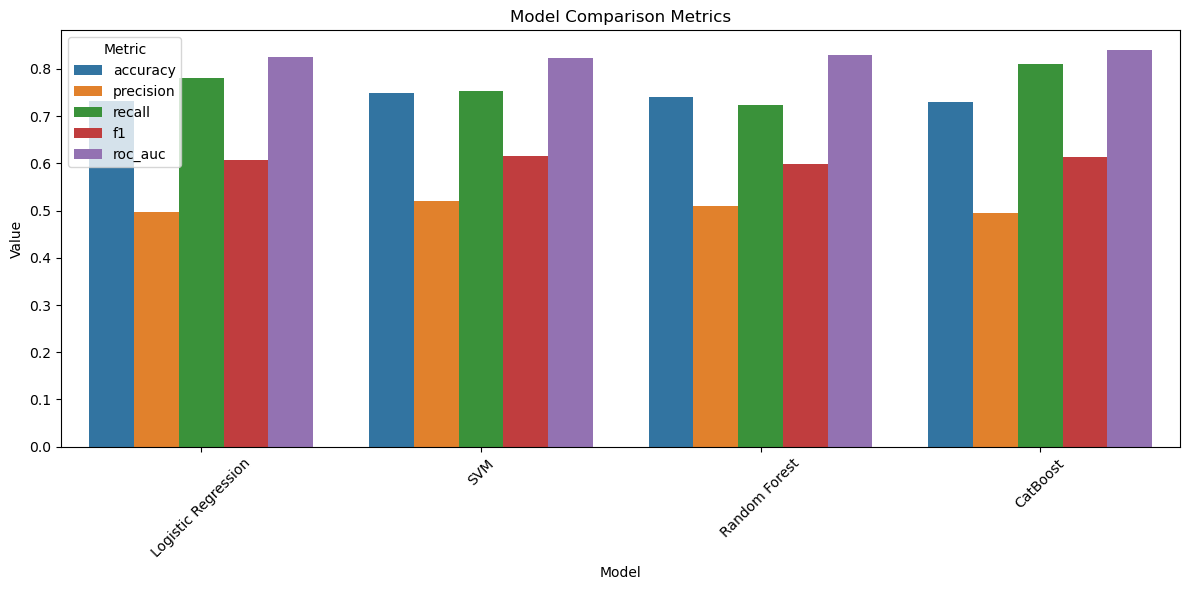

In [48]:
# comparision of model metrics
dynamic_df = pd.DataFrame.from_dict(
    {k: v["values"] for k, v in results.items()},
    orient='index'
).reset_index().rename(columns={'index': 'Model'})
dynamic_df = dynamic_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=dynamic_df, x='Model', y='Value', hue='Metric')
plt.title('Model Comparison Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Storing Results

Now, let's take a look at the same data in a tabular format for better readability. We will create a DataFrame to summarize the evaluation metrics for each model. We will also store the result in a CSV file for future reference.

In [49]:
results_df = pd.DataFrame.from_dict(
    {model: res["values"] for model, res in results.items()},
    orient='index'
)

# save results to CSV
results_df.to_csv(f"{RESULT_PATH}/{RESULT_FINE_NAME}-{datetime.now().strftime('%Y%m%d_%H%M%S')}.{RESULT_FINE_EXT}")

# The "RESULT_FINE_NAME" always contains the latest results
results_df.to_csv(f"{RESULT_PATH}/{RESULT_FINE_NAME}.{RESULT_FINE_EXT}")
results_df


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.731343,0.496599,0.780749,0.607069,0.825548
SVM,0.749112,0.519337,0.754011,0.615049,0.823439
Random Forest,0.741294,0.509398,0.724599,0.598234,0.828991
CatBoost,0.729211,0.494290,0.810160,0.613982,0.839865


#### Confusion Matrix
Next, we will plot the confusion matrices for each model to visualize how well they classify churned and non-churned customers. The confusion matrix shows the number of true positives, true negatives, false positives, and false negatives for each model.

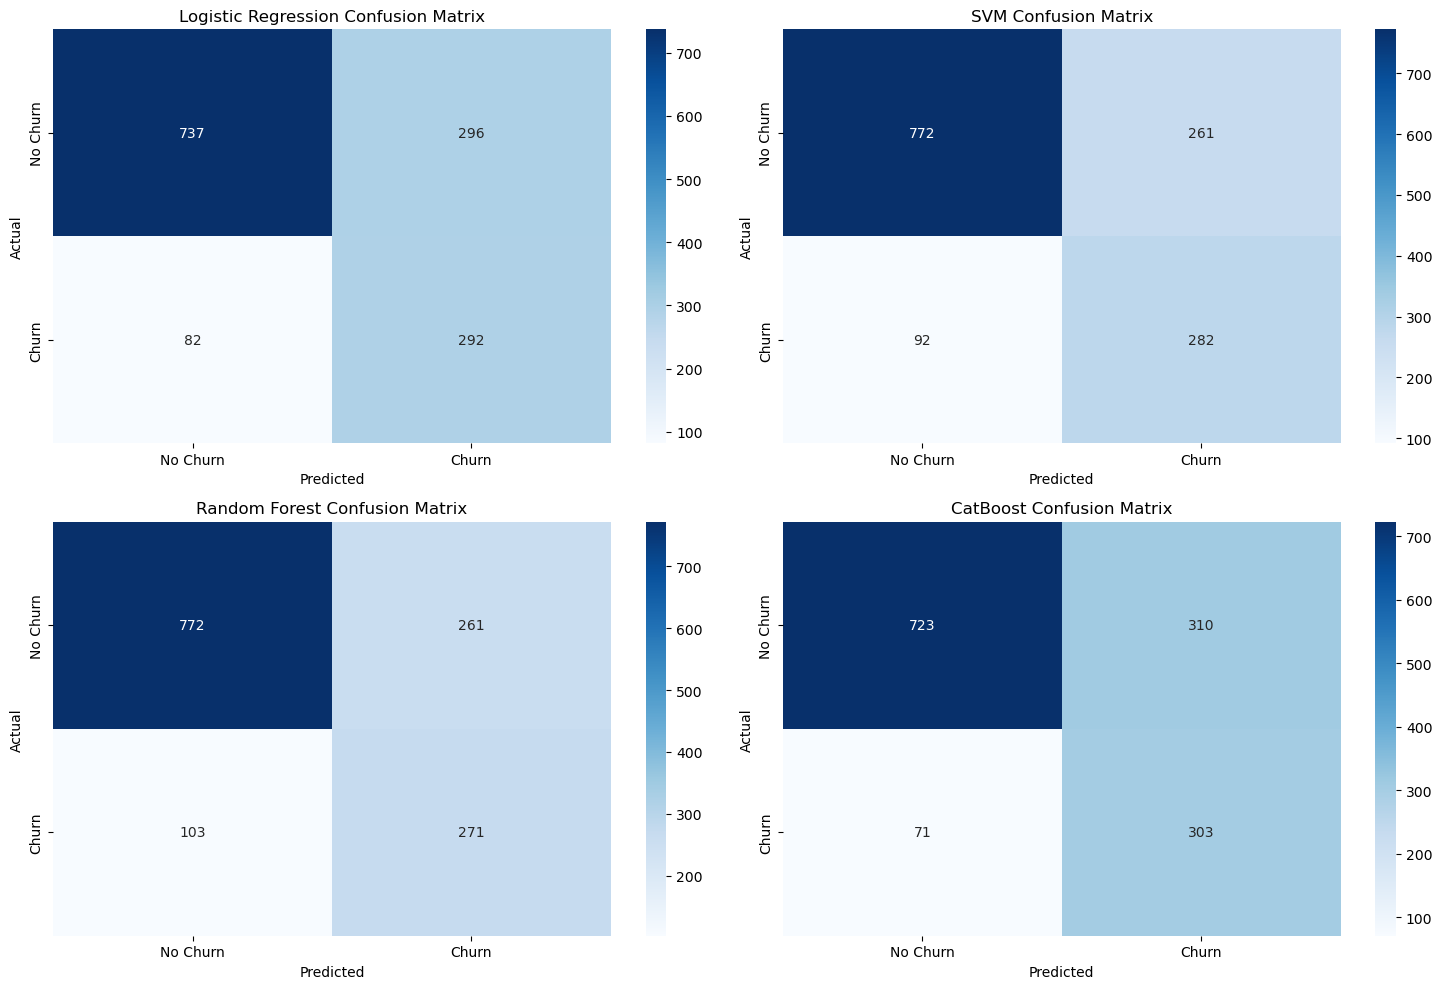

In [50]:
# confusion matrices
n_models = len(results)
cols = 2
rows = (n_models + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if n_models > 1 else [axes]
for i, (model_name, res) in enumerate(results.items()):
    cm = res["confusion_matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].set_xticklabels(["No Churn", "Churn"])
    axes[i].set_yticklabels(["No Churn", "Churn"])
plt.tight_layout()
plt.show()

#### ROC Curve
Finally, we will plot the ROC curves for each model to visualize their performance in terms of true positive rate (sensitivity) and false positive rate (1-specificity). The ROC curve shows how well the model distinguishes between churned and non-churned customers at different thresholds.

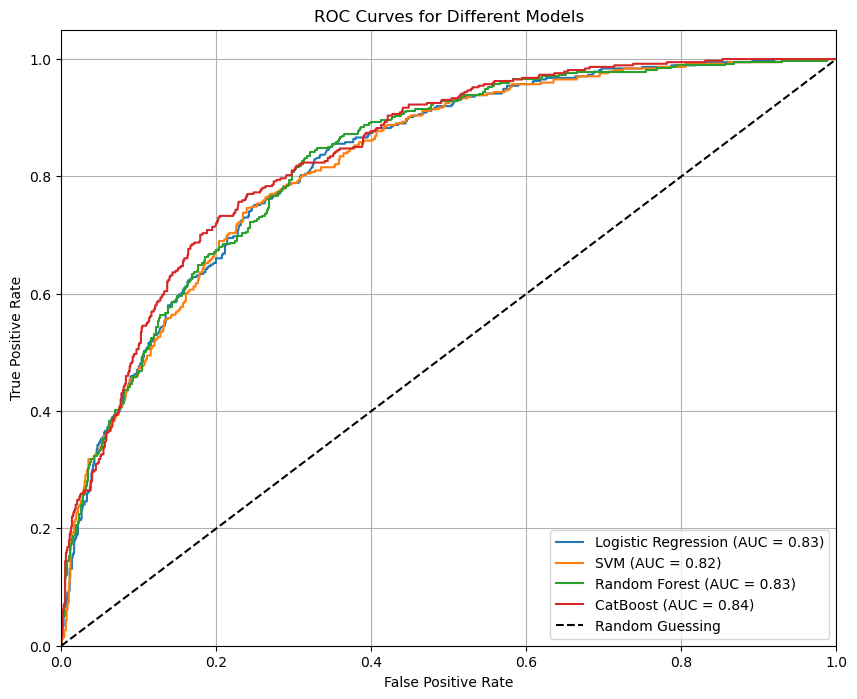

In [51]:
# plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, res in results.items():
    fpr = res["roc_curve"]["fpr"]
    tpr = res["roc_curve"]["tpr"]
    auc_score = res["roc_curve"]["roc_auc"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Different Models')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

##### ROC Curve Analysis

The **ROC curve** helps evaluate how well each model can distinguish between churners and non-churners. It plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** across different thresholds. The main summary metric is the **Area Under the Curve (AUC)**, the higher the AUC, the better the model is at classification.

From the ROC curve and AUC scores:

- **CatBoost** achieved the highest AUC of **0.84**, showing it is the best at separating the two classes among all models tested. This indicates that CatBoost has strong ranking performance, even though its accuracy is not the highest.
- **Random Forest** follows closely with an AUC of **0.829**, also performing well in distinguishing churners from non-churners.
- **Logistic Regression** and **SVM** both performed similarly with AUC scores around **0.825** and **0.823**, respectively. These models are still effective, but slightly weaker than the ensemble methods.

Overall, **all four models performed better than random guessing (AUC = 0.5)**, and ensemble models like CatBoost and Random Forest provided more reliable class separation, making them strong candidates for this churn prediction task.



### Model Performance Comparison

To evaluate the models on the Telco Customer Churn dataset, we used five classification metrics: **Accuracy**, **Precision**, **Recall**, **F1-score**, and **ROC AUC**. These metrics help us understand the models' strengths and weaknesses, especially since the dataset is imbalanced, with about 26.6% of customers labeled as churners.

| Model                | Accuracy | Precision | Recall | F1-score | ROC AUC |
|---------------------|----------|-----------|--------|----------|---------|
| Logistic Regression | 0.731    | 0.497     | 0.781  | 0.607    | 0.826   |
| SVM                 | 0.749    | 0.519     | 0.754  | 0.615    | 0.823   |
| Random Forest       | 0.741    | 0.509     | 0.725  | 0.598    | 0.829   |
| CatBoost            | 0.729    | 0.494     | **0.810**  | 0.614    | **0.840**   |

#### Accuracy
The SVM achieved the highest accuracy at 0.749, which means it made the most correct predictions overall. However, because the dataset is imbalanced, accuracy alone is not a reliable measure. A model may achieve high accuracy simply by predicting the majority class more often.

#### Precision and Recall
- **Precision** reflects how many of the predicted churners were actually correct. SVM had the highest precision (0.519), showing it was more selective when predicting churn.
- **Recall** shows how many actual churners were successfully identified. CatBoost performed best in this metric (0.810), meaning it identified the most churners, which is important for customer retention strategies.

#### F1-score
The F1-score is the harmonic mean of precision and recall. SVM and CatBoost scored similarly (0.615 and 0.614), showing that both have a balanced trade-off. SVM slightly favors precision, while CatBoost favors recall.

#### ROC AUC
The ROC AUC score shows the model’s ability to separate churners from non-churners across all thresholds. CatBoost achieved the highest score (0.840), indicating it is the best at ranking customers by their likelihood to churn.

#### Conclusion

Each model has its own strengths:

- **CatBoost** is the most suitable when the goal is to capture as many churners as possible. It has the highest recall and AUC, making it ideal for reducing customer loss.
- **SVM** is more balanced and has the highest precision, which could be useful when false positives are costly.
- **Random Forest** shows consistent performance but does not lead in any specific metric.
- **Logistic Regression** performs reasonably but is slightly weaker than the other models in most aspects.

In conclusion, **CatBoost** is the best model for this churn prediction task due to its strong overall performance, especially in recall and AUC.


## Feature Engineering

Feature engineering means creating new features or changing existing ones to help the model learn better. It can improve the model’s performance by showing patterns in the data that are not easy to see at first.

In this part, we create an **interaction feature** using two numerical columns. An interaction feature helps the model understand how two values work together.

### Create Interaction Feature

We added a new feature, `tenure_MonthlyCharges`, which is the product of `tenure` and `MonthlyCharges`. This feature captures the relationship between how long a customer has been with the company and how much they pay monthly. It can help the model understand that customers who have been with the company longer and pay more might be less likely to churn.


In [52]:

# Load and preprocess data
df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=True,
    map_gender=True,
    one_hot_encoding=True,
    scale_numeric=True,
    to_numeric=True,
)


# Split features/target
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Model 1: Baseline Logistic Regression
lr1 = LogisticRegression(random_state=42, max_iter=500)
lr1.fit(X_train, y_train)
y_pred1 = lr1.predict(X_test)
y_proba1 = lr1.predict_proba(X_test)[:, 1]

results = {}
results["Logistic Regression (no new feature)"] = {
    "accuracy": accuracy_score(y_test, y_pred1),
    "precision": precision_score(y_test, y_pred1),
    "recall": recall_score(y_test, y_pred1),
    "f1": f1_score(y_test, y_pred1),
    "roc_auc": roc_auc_score(y_test, y_proba1),
}


In [53]:

# Model 2: With Interaction Feature
X_train2 = X_train.copy()
X_test2 = X_test.copy()
X_train2['tenure_MonthlyCharges'] = X_train2['tenure'] * X_train2['MonthlyCharges']
X_test2['tenure_MonthlyCharges'] = X_test2['tenure'] * X_test2['MonthlyCharges']

lr2 = LogisticRegression(random_state=42, max_iter=500)
lr2.fit(X_train2, y_train)
y_pred2 = lr2.predict(X_test2)
y_proba2 = lr2.predict_proba(X_test2)[:, 1]

results["Logistic Regression (with interaction feature)"] = {
    "accuracy": accuracy_score(y_test, y_pred2),
    "precision": precision_score(y_test, y_pred2),
    "recall": recall_score(y_test, y_pred2),
    "f1": f1_score(y_test, y_pred2),
    "roc_auc": roc_auc_score(y_test, y_proba2),
}



In [54]:
# Save results to CSV
results_df = pd.DataFrame(results).T
results_df.to_csv(f"{RESULT_PATH}/{RESULT_FINE_NAME}-interaction-feature.{RESULT_FINE_EXT}")
results_df

,accuracy,precision,recall,f1,roc_auc
Logistic Regression (no new feature),0.786780,0.619355,0.513369,0.561404,0.832006
Logistic Regression (with interaction feature),0.788913,0.623794,0.518717,0.566423,0.832066


### Feature Engineering Analysis

Feature engineering is the process of creating new variables or modifying existing ones to help machine learning models learn better from the data. In this case, we introduced an **interaction feature** by multiplying two numerical features: `tenure` and `MonthlyCharges`. The new feature, named `tenure_MonthlyCharges`, is designed to capture the relationship between how long a customer has been with the company and how much they pay each month.

This interaction can provide extra information to the model. For example, customers who have both high tenure and high monthly charges might behave differently in terms of churn compared to those with only one of these factors.

To evaluate the effect of this feature, we used **Logistic Regression** as a **baseline model**. Logistic Regression was chosen because it is simple, interpretable, and sensitive to linear relationships between features and the target variable. This makes it a good starting point to observe the impact of new feature additions.

We then compared the model performance with and without the new interaction feature:

| Model                                | Accuracy | Precision | Recall | F1-score | ROC AUC |
|-------------------------------------|----------|-----------|--------|----------|---------|
| Logistic Regression (original)      | 0.787    | 0.619     | 0.513  | 0.561    | 0.832   |
| Logistic Regression (with feature)  | **0.789** | **0.624** | **0.519** | **0.566** | **0.832** |

#### Evaluation

- After adding the interaction feature, all performance metrics improved slightly, including accuracy, precision, recall, and F1-score.
- The ROC AUC score remained nearly the same (0.832), suggesting that the model’s ability to rank churners versus non-churners did not change significantly. However, the improvements in other metrics show better predictive performance.
- These results indicate that the new feature contributes positively to the model's ability to separate the classes.

Although the improvements were modest, they were consistent across all key metrics. This shows that even a simple interaction feature can help the model perform better. The experiment also demonstrates how Logistic Regression, due to its simplicity, can serve as an effective baseline for evaluating feature engineering efforts.



## Conclusion

This project explored customer churn prediction using the Telco Customer Churn dataset through a complete machine learning pipeline: from data cleaning and exploration to model evaluation and feature engineering. The dataset was moderately imbalanced, requiring techniques like SMOTE to address bias during training.

Exploratory Data Analysis (EDA) revealed several important patterns. Features such as `tenure`, `MonthlyCharges`, `Contract`, and use of services like `TechSupport` or `OnlineSecurity` showed strong associations with customer churn. We also identified multicollinearity between `TotalCharges` and other numerical features, which informed our model selection and feature usage strategies.

Multiple classification models were developed and compared using consistent preprocessing pipelines and evaluation metrics. Among them:

- **CatBoost** achieved the highest AUC (0.840) and recall (0.81), making it the most effective model for identifying churned customers.
- **SVM** offered the best balance between precision and recall and had the highest accuracy (0.749).
- **Random Forest** provided consistent performance across all metrics, and its feature importance analysis confirmed the value of previously identified predictors.
- **Logistic Regression**, used as a baseline, also performed reasonably well and was extended in a feature engineering experiment.

We introduced a new interaction feature (`tenure * MonthlyCharges`) and evaluated its effect using Logistic Regression. The addition led to small but consistent improvements in accuracy, precision, recall, and F1-score, confirming the benefit of feature engineering.

In conclusion, CatBoost is the most suitable model for churn prediction in this context, especially when recall and ranking performance are critical. The project also highlights the importance of proper preprocessing, careful metric selection for imbalanced data, and the value of domain-driven feature engineering. Future work could explore additional interaction features, model ensembles, or deployment strategies for real-time churn risk scoring.

